# Classification of NHL game data

## the idea

## theoretical background

As explained in chapter 13 in the book by Zaki and Meira [](#cite-zaki2014data), clustering is a way to group data into sets with common central points. The aim of clustering datasets is to inspect data structures which lay hidden to other statistical tools. Especially for multivariate datasets, a clustering may reveal interconnections between datapoints which may be hard to reveal starting from probabilistic measures, such as crosscorrelations. 

We use clustering methods on our purpose to see if there are similarities between games, judged from the cumulative statistics, so that they can be categorized together.

In [4]:
library(fpc)  
DATACAPTIONVEC <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE")

In the next step we read the input data as generated by the python class dataMiner.py. The input data consists of data with postfix Delta and Sum, with Sum data defined as $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{D}^{d}$ and $X_{\Sigma}=X_{h}+X_{a}$ with $X_{h,a} \in \mathbb{D}^{d}$ ($\mathbb{D}$ a mixture of binary and natural numbers), d dimensional home and away team statistics vectors. In our case every datasample has 16 entries,with 10 numerical attributes per dataset, giving d=10. The first 6 attributes of each dataset like season, game id and teams who played contain supplementery information and are important only in the preprocessing process. We may write our dataset as "set" $X_{\Delta,Sum} = F ( x_{won},x_{score},x_{shots},x_{faceoff},x_{takeaway},x_{giveaway},x_{pim},x_{hits},x_{ppg},x_{attendance} )$ with F a function of the datasets for home and away teams, as described above. $x_{won}$ takes binary values $x_{won} \in [0,1]$, 0 for loss and 1 for game won. The other attributes take integer values.

In [8]:
print("The categories stored in the data set are")
print(paste(DATACAPTIONVEC))

[1] "The categories stored in the data set are"
 [1] "ID"         "SEASON"     "DATE"       "TEAM1"      "TEAM2"     
 [6] "WON"        "SCORE"      "SHOTS"      "FACEOFF"    "TAKEAWAY"  
[11] "GIVEAWAY"   "PIM"        "HITS"       "PPG"        "ATTENDANCE"


In [9]:
nhlDataSum=data.frame()
nhlDataDelta=data.frame()
SeasonVector=c(2010,2011,2012,2014,2015,2016)
NumberOfSeasons=length(SeasonVector)
for(season in SeasonVector)
{
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_sum.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataSum<-rbind(nhlDataSum,nhlDataS)
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_delta.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataDelta<-rbind(nhlDataDelta,nhlDataS)
}
colnames(nhlDataSum) <- DATACAPTIONVEC
colnames(nhlDataDelta) <- DATACAPTIONVEC
print("The dataset read contains ")
print(paste(nrow(nhlDataDelta),ncol(nhlDataDelta)))
print("rows and columns.")

[1] "The dataset read contains "
[1] "6603 15"
[1] "rows and columns."


## some more data preprocessing

The datavectors $X_{Sum},X_{\Delta}$ are now combined to give individual teams statistics. For home games we can simply add the two $X_{team,h}={1 \over 2} \{ X_{Sum} + X_{\Delta} \}$, for the away team stats we have to invert $X_{\Delta}$: $X_{team,a}={1 \over 2} \{ X_{Sum} - X_{\Delta} \}$, and finally add the two: $X_{team}=X_{team,h}+X_{team,a}$ to obtain the overall game stats. We are doing this for all the teams contained in the statistics, which are the following:

In [11]:
teams <- nhlDataDelta$TEAM1
LISTOFTEAMS=unique(teams)
print("we have the following teams")
print(LISTOFTEAMS)

[1] "we have the following teams"
 [1] BOS       TOR       COL       CGY       CAR       PIT       CHI      
 [8] DET       BUF       NJ        NYI       NYR       WSH       ATLANTA  
[15] FLA       CBJ       DAL       STL       EDM       ANA       LA       
[22] VAN       PHI       MIN       TB        NSH       SJ        PHO      
[29] CANADIENS OTT       WPG       MTL       ARI      
33 Levels: ANA ATLANTA BOS BUF CANADIENS CAR CBJ CGY CHI COL DAL DET ... ARI


A function performs now the inverting part of $X_{\Delta}$.

In [8]:
getTeamGameStatistics <- function(thisTeam)
    {
    matchS<-subset(nhlDataSum,nhlDataSum$TEAM1==thisTeam | nhlDataSum$TEAM2==thisTeam)
    matchH<-subset(nhlDataDelta,nhlDataDelta$TEAM1==thisTeam)
    matchA<-subset(nhlDataDelta,nhlDataDelta$TEAM2==thisTeam)
    
    #invert away data
    matchA$SCORE=-matchA$SCORE
    matchA$SHOTS=-matchA$SHOTS
    matchA$FACEOFF=-matchA$FACEOFF
    matchA$TAKEAWAY=-matchA$TAKEAWAY
    matchA$GIVEAWAY=-matchA$GIVEAWAY
    matchA$PIM=-matchA$PIM
    matchA$HITS=-matchA$HITS
    matchA$PPG=-matchA$PPG

    #add delta data
    matchD<-rbind(matchH,matchA)
    #now order for data then season
    tmp<-matchD[order(matchD$DATE),]
    matchDOrdered<-tmp[order(tmp$SEASON),]

    #compute the NYI values by combining delta and summed data
    teamData=0.5*(matchDOrdered[,sapply(matchDOrdered,is.numeric)]+matchS[,sapply(matchS,is.numeric)])
    return(teamData)
    }

In [9]:
teamsDataList <- list()
for(i in 1:length(LISTOFTEAMS))
{
team=LISTOFTEAMS[i]
#team="NYI"
teamsDataList[[i]] <- getTeamGameStatistics(team)
}
#teamsDataList <- mapply(getTeamGameStatistics,unlist(LISTOFTEAMS))
print(paste("Have retrieved a data list of size",length(teamsDataList),"for ",length(LISTOFTEAMS),"teams"))
#print(lapply(teamsDataList,dim))

[1] "Have retrieved a data list of size 33 for  33 teams"


In [10]:
teamToAnalyze="NYI"
print(paste("We analyze data for team",teamToAnalyze))
matchNYI<-getTeamGameStatistics(teamToAnalyze)

[1] "We analyze data for team NYI"


## clustering with kmeans

To see if games cluster around common score values we cluster game data using the full dataset $X_{team}$, but omitting the won and score parts of the data. (We are for the moment also not interested in the number of spectators viewing the game. $X_{team,cluster} = X_{team} \setminus \{x_{team,won},x_{team,score},x_{team,attendance}\}$.

In [12]:
matchNYIMatrix=as.matrix(cbind(matchNYI$SHOTS,matchNYI$FACEOFF,matchNYI$HITS,matchNYI$TAKEAWAY,matchNYI$GIVEAWAY,matchNYI$PIM,matchNYI$PPG))
print(paste("We analyze",nrow(matchNYIMatrix),"games of team",teamToAnalyze,"characterized by",ncol(matchNYIMatrix),"attributes."))

[1] "We analyze 488 games of team NYI characterized by 7 attributes."


We will classify the game data by using the k-means algorithm, which clusters datapoints around mean centroid values of cluster datasets.
As explained in algorithm 13.1 in [](#cite-zaki2014data), given the number of clusters to expect, say k, k points in d dimensional data space are selected as start values of cluster mean points. Clustering the data means to assign to each of these k points the nearest datapoints in the datasets, with nearest in the sense of the norm of a distance function. As we are left with k clusters, we compute in the next step the intra-cluster mean values, updating the initial k mean values. In the following we reassign all the points to the newly evaluated cluster means. This iterative procedure, when converged, optimally leads to k clearly distinctive clusters of datapoints.
A neat R library implementing clustering algorithms is fpc.

In [23]:
library(fpc)  
#colnames(matchNYIMatrix)<-c("WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","PIM")
clusterResult=kmeansruns(matchNYIMatrix,krange=2:22,criterion="ch",iter.max=100,runs=5,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=FALSE)

In [24]:
print(paste("The algorithm has estimated the best kernel size to be",clusterResult$bestk))

[1] "The algorithm has estimated the best kernel size to be 5"


In [26]:
#clusterResult=kmeansruns(matchNYIMatrix,krange=5,criterion="ch",iter.max=100,runs=5,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=TRUE)

To evaluate the results we do some data manipulation. We look at the distance between the found cluster centers and compare these differences with the span of the overall datarange.

In [27]:
  print("The algorithm found the following data cluster centers:")
  colnames=c("SHOTS","FACEOFF","HITS","TAKEAWAY","GIVEAWAY","PIM","PPG")
  
  sumClusterPoints=sum(clusterResult$size)
  for(i in 1:nrow(clusterResult$centers))
  {
    print(paste("cluster",i,"contains a fraction of",clusterResult$size[i]/sumClusterPoints,"points and has the following center values for the categories:"))
    for(j in 1:ncol(clusterResult$centers))
    {
      print(paste("center for category",colnames[j],"is",clusterResult$centers[i,j]))
    }
  }
  print("==================================")
  
  #now evaluate maximum distance measures
  print("evaluate maximum distance measures")
  print("==================================")
  
  for(j in 1:ncol(clusterResult$centers))
  {
    maxCenterDistance=max(clusterResult$centers[,j])-min(clusterResult$centers[,j])
    maxDataDistance=max(dataMatrix[,j])-min(dataMatrix[,j])
    print(paste("the maximum centroid distance for category ",colnames[j]," divided by max/min values is",maxCenterDistance/maxDataDistance))
  } 

[1] "The algorithm found the following data cluster centers:"
[1] "cluster 1 contains a fraction of 0.204918032786885 points and has the following center values for the categories:"
[1] "center for category SHOTS is 31.43"
[1] "center for category FACEOFF is 23.63"
[1] "center for category HITS is 38.67"
[1] "center for category TAKEAWAY is 9.08"
[1] "center for category GIVEAWAY is 10.32"
[1] "center for category PIM is 8.27"
[1] "center for category PPG is 0.5"
[1] "cluster 2 contains a fraction of 0.100409836065574 points and has the following center values for the categories:"
[1] "center for category SHOTS is 29.4489795918367"
[1] "center for category FACEOFF is 20.9795918367347"
[1] "center for category HITS is 24.0408163265306"
[1] "center for category TAKEAWAY is 7.79591836734694"
[1] "center for category GIVEAWAY is 7.89795918367347"
[1] "center for category PIM is 30.6326530612245"
[1] "center for category PPG is 0.469387755102041"
[1] "cluster 3 contains a fraction of 0.2868

ERROR: Error in dataMatrix[, j]: subscript out of bounds


To check whether the different groups show a disparate scoring statistics we plot the scores as a scatter plot for the various datasets into one plot. 

In [ ]:
clusterResult=kmeansruns(matchNYIMatrix,krange=3,criterion="ch",iter.max=100,runs=1,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=TRUE)

## cluster analysis of home game data

In [22]:
dataMatrix <- matrix()
dataMatrix <- as.matrix(cbind(nhlDataDelta$SCORE))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$SHOTS))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$FACEOFF))
print(paste("dataMatrix with",ncol(dataMatrix),"columns and",nrow(dataMatrix),"rows!"))

[1] "dataMatrix with 3 columns and 7275 rows!"


In [23]:
clusterResult=kmeansruns(dataMatrix,krange=2,criterion="ch",iter.max=150,runs=1,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=FALSE)
print(clusterResult$centers)
print(clusterResult$size)
print(clusterResult$bestk)
print(clusterResult$crit)

       [,1]      [,2]       [,3]
1 0.3625137  9.703348  3.1174533
2 0.2090333 -6.077114 -0.1985679
[1] 3644 3631
[1] 2
[1]    0.000 4987.108


In [28]:
dataMatrix <- matrix()
dataMatrix <- as.matrix(cbind(nhlDataDelta$SCORE))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$SHOTS))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$FACEOFF))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$TAKEAWAY))
dataMatrix <- as.matrix(cbind(dataMatrix,nhlDataDelta$PPG))
print(paste("dataMatrix with",ncol(dataMatrix),"columns and",nrow(dataMatrix),"rows!"))

[1] "dataMatrix with 5 columns and 7275 rows!"


In [31]:
clusterResult=kmeansruns(dataMatrix,krange=2:12,criterion="ch",iter.max=150,runs=1,scaledata=FALSE,alpha=0.001,critout=TRUE,plot=FALSE)
print(clusterResult$centers)
print(clusterResult$size)
print(clusterResult$bestk)
print(clusterResult$crit)

2  clusters  4253.764 
3  clusters  3510.085 
4  clusters  3407.732 
5  clusters  3092.962 
6  clusters  2864.851 
7  clusters  2718.037 
8  clusters  2542.459 
9  clusters  2436.43 
10  clusters  2330.348 
11  clusters  2222.217 
12  clusters  2150.145 
       [,1]      [,2]       [,3]     [,4]       [,5]
1 0.2105843 -6.090959 -0.1645535 1.958931 0.06146637
2 0.3608445  9.704140  3.0808884 2.103647 0.14834110
[1] 3628 3647
[1] 2
 [1]    0.000 4253.764 3510.085 3407.732 3092.962 2864.851 2718.037 2542.459
 [9] 2436.430 2330.348 2222.217 2150.145


In [19]:
clusterResult=disthclustCBI(dataMatrix,krange=2,method=fixmahal,criterion="ch",iter.max=150,runs=1,scaledata=FALSE,alpha=0.001,critout=FALSE,plot=TRUE)

ERROR: Error in method == "ward": comparison (1) is possible only for atomic and list types


In [13]:
clusterResult=pamkCBI(dataMatrix,krange=2,k=2,criterion="asw", usepam=TRUE,scaling=TRUE,diss=inherits(data,"dist"))

## agglomerative clustering

In the next step we want to compare Islanders games and ask ourselves if we can find categorical similarities in games. To this end we apply an agglomerative clustering algorithm. As described in Zaki and Meira [](#cite-zaki2014data), the algorithm starts with N-datavectors  $x_{i=1..N} \in \mathbb{R}^{d}$. In a first step, using a chosen metric M, the distance between the N elements is computed and stored in a symmetric $N \times N$ matrix. Starting with N clusters, in each successive step nearest neighbours are combined, or agglomerated, into clusters. 

For our analysis we take the islanders home game data of the actual season, 2016. As starting dataset we choose the delta dataset $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{N}^{d}$ home and away team stats respectively. In the next, filtering step we intersect the dataset to get $X_{islanders} = \{X_{\Delta} \in X | x^{team}=NYI \cap    x^{season}=2016 \} $. In the resulting data we do not include the score, as we want to know if the clusters agglomerate around certain score values. The score is introduced in the labelling of the clusters.

In [32]:
  tmp<-subset(nhlDataDelta,nhlDataSum$TEAM1=="NYI")
  dataSubset<-subset(tmp,tmp$SEASON==2016)
  dataMatrix <- as.matrix(cbind(dataSubset$SHOTS,dataSubset$PIM,dataSubset$PPG,dataSubset$TAKEAWAY,dataSubset$GIVEAWAY,dataSubset$HITS))
print(paste(nrow(dataMatrix),ncol(dataMatrix)))

[1] "25 6"


The computation of the distance matrix is performed using the euclidean norm $L_{2}$.

In [33]:
  ddM=dist(dataMatrix,method="euclidean")

We number the row numbers to get the correct game numbering and assemble the labels giving game number, team played against and the score difference, being positive for games won and negative for lost games.

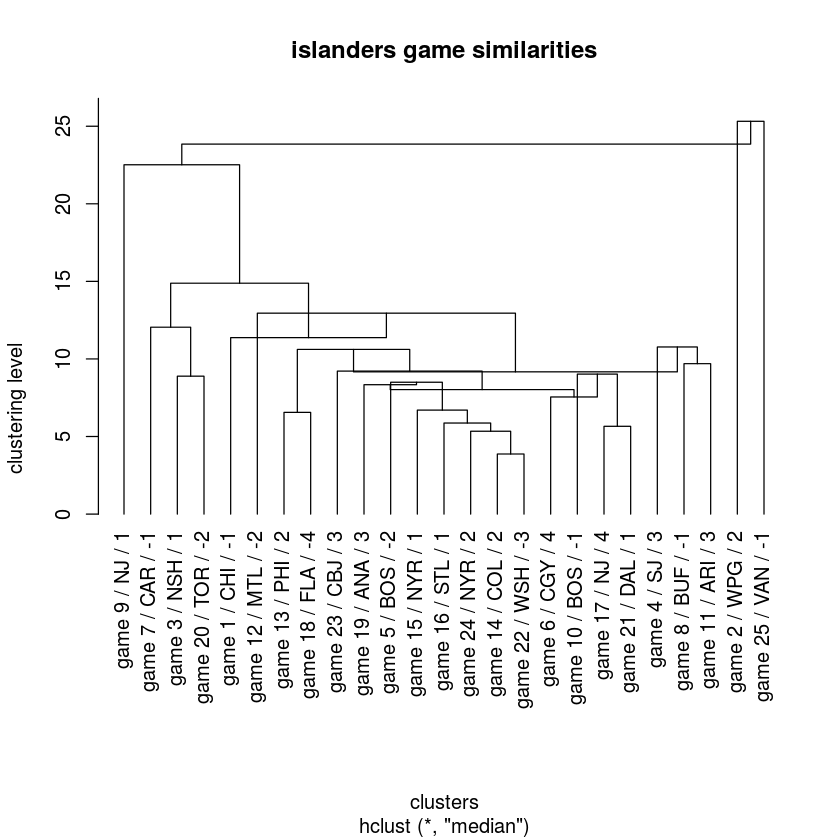

In [34]:
  rownames(dataSubset) <- 1:nrow(dataSubset)
  labelsV=as.vector(paste("game",rownames(dataSubset),"/",dataSubset$TEAM2,"/",dataSubset$SCORE))
  hcm<-hclust(ddM,"median")
  plot(hcm,labels=labelsV,main="islanders game similarities",xlab="clusters",ylab="clustering level",hang=-2)  

In [35]:
  tmp<-subset(nhlDataDelta,nhlDataSum$TEAM1=="NYI")
  dataSubset<-subset(tmp,nhlDataSum$TEAM2=="NYR")
  dataMatrix <- as.matrix(cbind(dataSubset$SHOTS,dataSubset$PIM,dataSubset$PPG,dataSubset$TAKEAWAY,dataSubset$GIVEAWAY,dataSubset$HITS))
print(paste(nrow(dataMatrix),ncol(dataMatrix)))

[1] "215 6"


In [36]:
  ddM=dist(dataMatrix,method="euclidean")

ERROR: Error in hclust(ddM, "median"): NA/NaN/Inf in foreign function call (arg 11)


ERROR: Error in graphics:::plotHclust(n1, merge, height, order(x$order), hang, : invalid dendrogram input


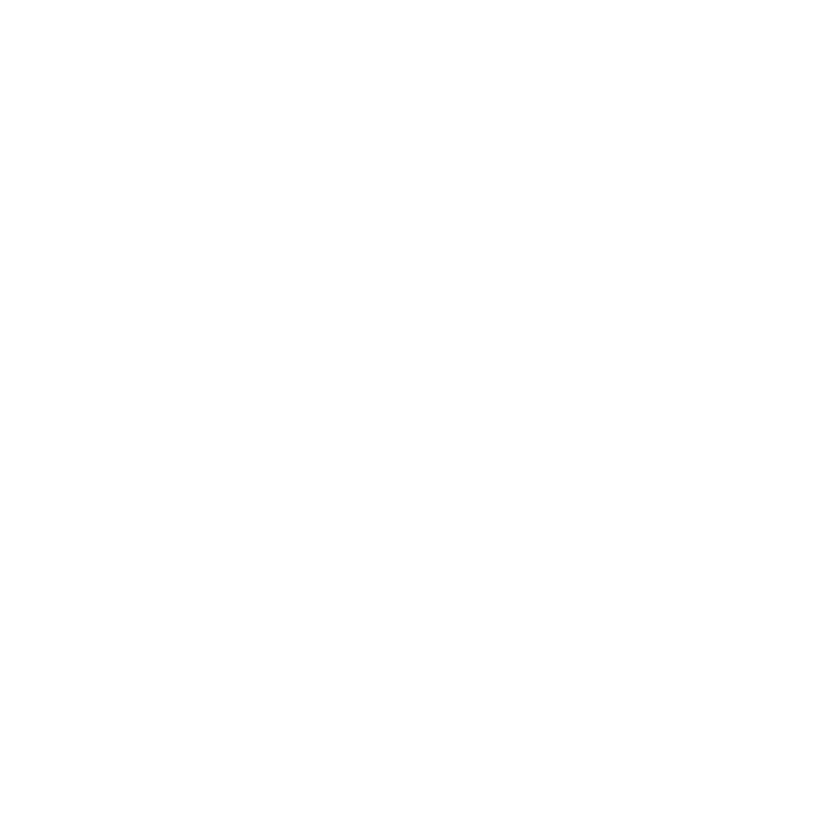

In [37]:
  rownames(dataSubset) <- 1:nrow(dataSubset)
  labelsV=as.vector(paste("game",rownames(dataSubset),"/",dataSubset$TEAM2,"/",dataSubset$SCORE))
  hcm<-hclust(ddM,"median")
  plot(hcm,labels=labelsV,main="islanders game similarities",xlab="clusters",ylab="clustering level",hang=-2)  